In [1]:
%load_ext autoreload
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from PIL import *
import cv2

import time
import math

import torch
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import box_iou
import pytorch_lightning as pl
from tqdm.cli import tqdm as tq

from statistics import mean
from typing import Tuple, Dict, Iterable

from pangu_dataset_mask import load_bounding_boxes, load_projected_ellipses, compute_mask, plot_ellipses, plot_masks
from pangu_dataset_mask import CraterDataset, get_ellipse_from_mask

In [2]:
autoreload 2

In [3]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 200

In [4]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
model = maskrcnn_resnet50_fpn(
    pretrained = True,
)

# Change number of output classes to two ( no-crater, crater )
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = FastRCNNPredictor( in_features, num_classes = 2 )

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = ( param_size + buffer_size ) / 1024 ** 2
print('model size: {:.3f}MB'.format(size_all_mb))

/home/sofia/miniconda3/envs/pyenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sofia/miniconda3/envs/pyenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model size: 168.043MB


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [7]:
path = "training_checkpoints/mask_rcnn_18.blob"
# path = "training_checkpoints_fewer_craters/mask_rcnn_6.blob"
model.load_state_dict( torch.load( path ) )
model.eval()
model.to( device )
print( 'Loaded:', path )

/tmp/ipykernel_17077/2852463644.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict( torch.load( path ) )


Loaded: training_checkpoints/mask_rcnn_15.blob


In [8]:
# Load Robins crater database:
craters = pd.read_csv( '../data/craters_with_stats_-90_-45_0_90.csv' ).dropna()
craters = craters.loc[:, ~craters.columns.str.contains('^Unnamed')]
craters['medianDifference'] = ( craters['rimMedian'] - craters['fullMedian'] ).abs()

In [9]:
# Build CDA database (typically takes about a minute)
img_size = (1024, 1024)
root_dir = "../data/"
ldem_name = "LDEM_-90_-45E_0_45N_all_ellipses"
min_angle = 20
max_angle = 70
angle_inc = 5

cd = CraterDataset(craters, img_size, root_dir, ldem_name, min_angle, max_angle, angle_inc, None, True, True)

Filter bad samples:
Total Images after Filtering 2500


In [10]:
# Return the batch as an iterable, skipping 'None' samples
def collate_fn(batch: Iterable):
    return tuple( zip( *( filter( lambda x:x is not None, batch ) ) ) )

In [11]:
# Define your dataset
inference_dataset = torch.utils.data.Subset(cd, range(len(cd)))  # or a custom dataset as required

# Define the DataLoader for the inference dataset
inference_data_loader = torch.utils.data.DataLoader(
    inference_dataset,
    batch_size=8,
    shuffle=False,  # No shuffling during inference
    num_workers=16,
    collate_fn=collate_fn  # Ensure this matches your dataset requirements
)

In [12]:
predictions = []

import gc

with torch.no_grad():
    bar = tq( inference_data_loader, desc = f"Predictions" )
    
    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        images = list( image.to( device ) for image in images )

        # Make predictions
        p = model( images )
        # Move predictions to RAM
        p = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in p ]

        # Postprocess mask into ellipse parameters
        for sample in p:
            sample['ellipse_sparse'] = []

            for masks in sample['masks']:
                for mask in masks.numpy():
                    try:
                        x,y,a,b,theta = get_ellipse_from_mask(mask)
                        if not(x==0 and y==0 and b==0 and theta==0):
                            sample['ellipse_sparse'].append( [ x, y, a, b, theta ] )
                    except:
                        print("Error:", mask)
                        print(mask)
                        print(len(mask))
                        print(masks)
                        print(sample['masks'])
                        # sample['ellipse_sparse'].append( [] )

            del sample['masks']
        
        predictions.extend( p )
        gc.collect()


Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

Predictions:  43%|████▎     | 136/313 [10:10<13:31,  4.59s/it]

Error: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


Predictions:  44%|████▍     | 137/313 [10:14<12:16,  4.18s/it]

Error: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Error: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


Predictions:  87%|████████▋ | 271/313 [19:34<02:20,  3.35s/it]

Error: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


Predictions: 100%|██████████| 313/313 [21:53<00:00,  4.20s/it]


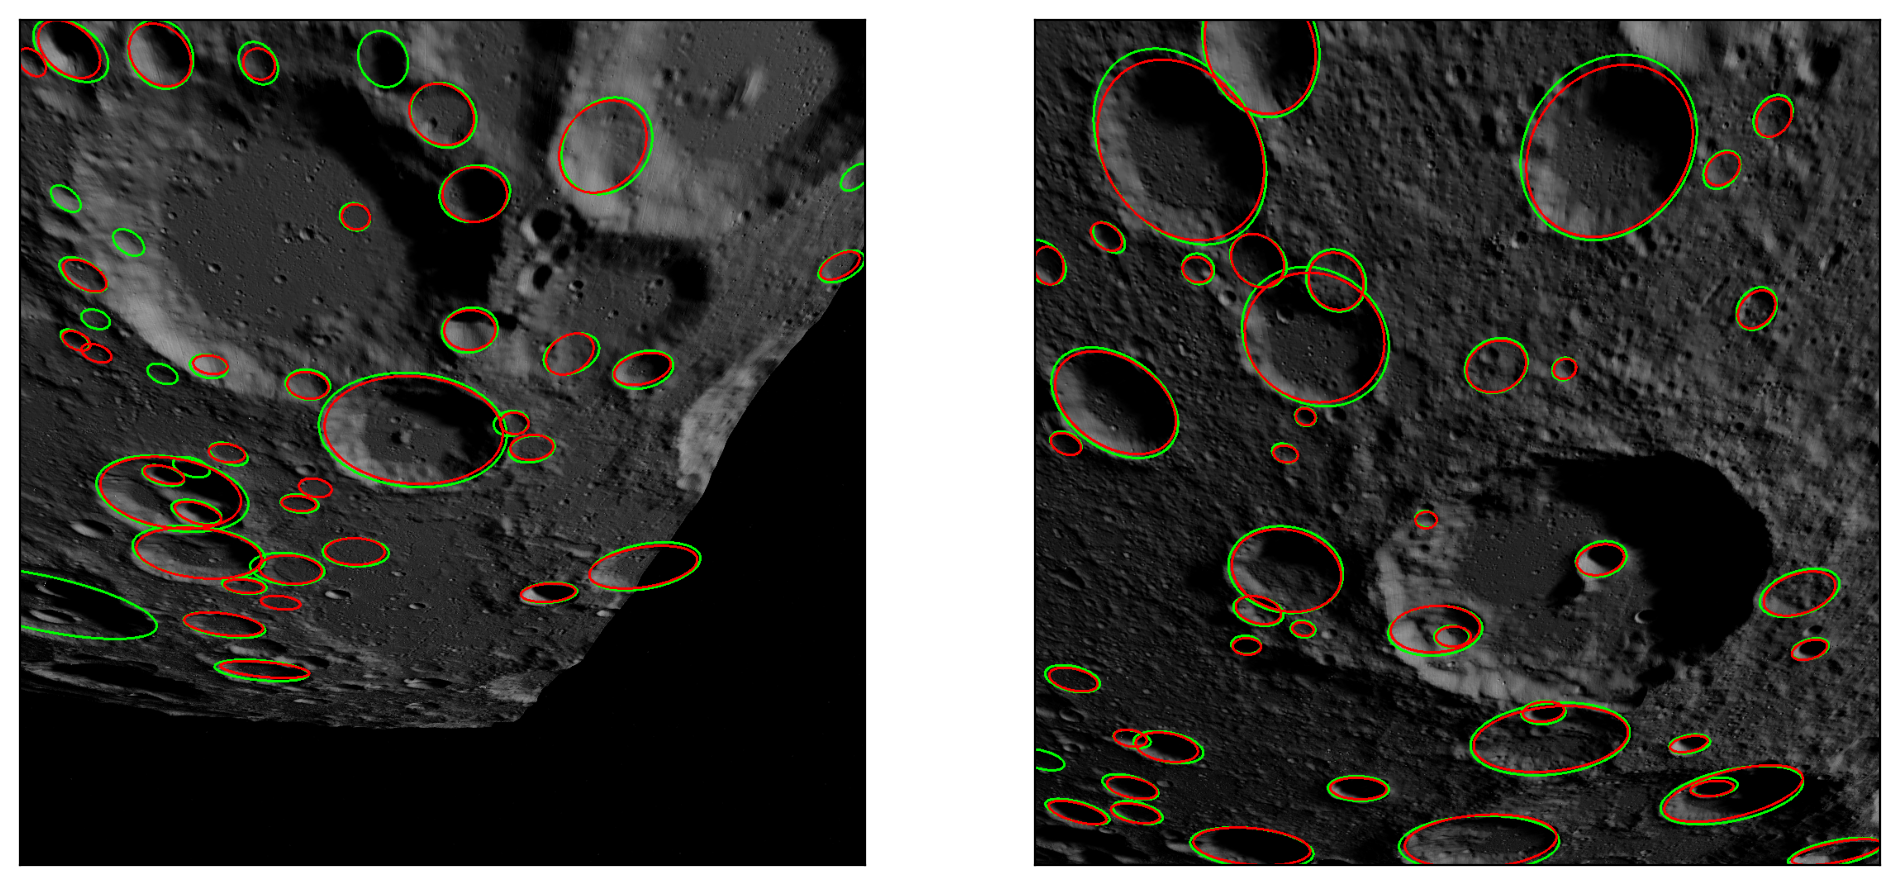

In [17]:
# Show a random sample of predictions
n_samples = 2
fig, ax = plt.subplots( ncols = n_samples )

pred_threshold = 0.7

testIndices = range(len(cd))


for i in range( n_samples ):
    test_set_index = int( np.random.rand() * len( testIndices ) )
    dataset_index = testIndices[test_set_index]
    img, target = cd.__getitem__( dataset_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )
    
    # Apply prediction confidence mask
    mask = predictions[test_set_index]['scores'] > 0.7
    # mask = np.array(mask, dtype=np.uint8)
    
    # ground truth
    img = plot_masks( img, target['boxes'], target['masks'], color = ( 0, 1, 0 ), color_channel = 1, plot_box = False, plot_mask = False, plot_ellipse = True)

    # predicted
    img = plot_ellipses( img, predictions[test_set_index]['boxes'][mask], np.array(predictions[test_set_index]['ellipse_sparse'])[mask], color = ( 1, 0, 0 ), plot_boxes=False )

    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
    
plt.show()